In [1]:
import json
import pandas as pd

In [2]:
with open('../data/SilasMarner/coref_merge_map.json') as f:
    coref_map = json.load(f)

quotes_df = pd.read_csv('../data/SilasMarner/character-tagging/SilasMarner.quotes', delimiter='\t')
entities_df = pd.read_csv('../data/SilasMarner/processed_characters.csv')

In [3]:
quotes_df

,quote_start,quote_end,mention_start,mention_end,mention_phrase,char_id,quote
0,1003,1017,1018,1018,I,0,Is there anything you can fancy that you woul...
1,1047,1050,1051,1051,he,221,"No ,"
2,1054,1073,1051,1051,he,221,I 've never been used to nothing but common v...
3,1444,1446,1450,1450,his,32,North'ard
4,1720,1724,1698,1698,he,32,Good - night
...,...,...,...,...,...,...,...
964,86229,86235,86236,86236,he,329,"Well , Master Marner ,"
965,86248,86312,86236,86236,he,329,I 've lived to see my words come true . I was...
966,86314,86345,86236,86236,he,329,", and willing , at the holy matrimony ; but T..."
967,86666,86670,86672,86672,Eppie,144,"O father ,"


In [4]:
from typing import List, Set
from dataclasses import dataclass


@dataclass
class Quote:
    text: str
    speaker_id: int


@dataclass
class Dialogue:
    start_token: int
    end_token: int
    quotes: List[Quote]
    involved_characters: Set[int]


dialogue_join_threshold_tokens = 150


dialogues = []

for i, row in quotes_df.iterrows():

    if i == 0 or row.quote_start - dialogues[-1].end_token > dialogue_join_threshold_tokens:
        dialogues.append(Dialogue(start_token=row.quote_start, end_token=row.quote_end, quotes=list(), involved_characters=set()))
    
    dialogues[-1].end_token = row.quote_end
    dialogues[-1].quotes.append(Quote(text=row.quote, speaker_id=row.char_id))
    dialogues[-1].involved_characters.add(row.char_id)

len(dialogues) and dialogues[1]

Dialogue(start_token=1444, end_token=1446, quotes=[Quote(text=" North'ard ", speaker_id=32)], involved_characters={32})

In [5]:
entities_df

,Unnamed: 0,COREF,start_token,end_token,prop,cat,text,character_name
0,48,32,533,534,PROP,PER,Silas Marner,"father Silas , who had taken her golden curls ..."
1,49,32,538,538,PRON,PER,his,"father Silas , who had taken her golden curls ..."
2,55,32,573,573,PROP,PER,Silas,"father Silas , who had taken her golden curls ..."
3,61,32,675,675,PROP,PER,Marner,"father Silas , who had taken her golden curls ..."
4,62,32,683,683,PRON,PER,his,"father Silas , who had taken her golden curls ..."
...,...,...,...,...,...,...,...,...
6563,11688,32,86599,86599,PROP,PER,Silas,"father Silas , who had taken her golden curls ..."
6564,11690,61,86605,86605,PRON,PER,he,the artful Godfrey
6565,11691,144,86607,86607,PROP,PER,Eppie,little curly - headed Eppie
6566,11699,144,86672,86672,PROP,PER,Eppie,little curly - headed Eppie


In [6]:
char_id_lookup = {row.COREF: row.character_name for i, row in entities_df.iterrows()}
char_id_lookup.update({key: char_id_lookup[val] for key, val in coref_map.items() if val in char_id_lookup})
char_id_lookup_reverse = {val: key for key, val in char_id_lookup.items()}
char_id_lookup

{32: 'father Silas , who had taken her golden curls for his lost guineas brought back to him',
 34: 'Jem Rodney',
 35: 'old Squire Cass',
 36: 'the argumentative Mr. Macey',
 37: 'Old Master Marner',
 38: 'Sally Oates',
 41: 'William Dane',
 43: 'God Almighty',
 45: 'Poor Marner',
 1: 'the Raveloe',
 48: 'Mrs. Osgood',
 54: 'the Mr. Osgood',
 58: 'Dunstan Cass',
 59: 'Dunsey Cass',
 61: 'the artful Godfrey',
 62: 'Miss Nancy Lammeter',
 66: 'Molly Farren',
 68: 'Wildfire',
 69: 'old Bryce',
 74: 'Miss Priscilla Lammeter',
 75: 'young Mr. Lammeter',
 76: 'Mr. Snell',
 80: 'Master Tookey',
 81: 'Mrs. Winthrop',
 82: 'Mr. Crackenthorp',
 83: 'Ben Winthrop',
 84: 'Dolly Winthrop',
 86: 'Solomon Macey',
 89: 'Mr. Drumlow',
 91: 'Mr. Cliff',
 94: 'Master Dowlas',
 101: 'Master Dunsey',
 114: 'uncle Kimble',
 118: 'good - natured Mrs. Kimble',
 119: 'the Miss Gunns',
 124: 'Miss Gunn',
 126: 'Priscy',
 129: 'Mrs. Crackenthorp',
 141: 'Baby',
 144: 'little curly - headed Eppie',
 149: 'Mrs. Go

In [7]:
character_of_interest = 'father Silas , who had taken her golden curls for his lost guineas brought back to him'

del_idxs = []
filtered_dialogues = [dialogue for dialogue in dialogues if char_id_lookup_reverse[character_of_interest] in dialogue.involved_characters]
len(filtered_dialogues)

30

In [8]:
other_characters = set()
for dialogue in filtered_dialogues:
    other_characters = other_characters.union(dialogue.involved_characters)

other_characters.remove(char_id_lookup_reverse[character_of_interest])
other_characters

{34,
 36,
 37,
 41,
 45,
 61,
 62,
 81,
 82,
 84,
 108,
 109,
 111,
 114,
 118,
 141,
 144,
 149,
 259,
 267,
 300,
 334,
 444,
 528,
 759,
 764,
 916,
 1166,
 1450,
 1534,
 1535,
 1752,
 1949,
 1986,
 2340}

In [9]:
filtered_other_characters = [char_id_lookup[char] for char in other_characters if char in char_id_lookup]
filtered_other_characters

['Baby',
 'little curly - headed Eppie',
 'Mrs. Godfrey Cass',
 'Jem Rodney',
 'the argumentative Mr. Macey',
 'Old Master Marner',
 'William Dane',
 'Poor Marner',
 'the artful Godfrey',
 'Miss Nancy Lammeter',
 'Mrs. Winthrop',
 'Mr. Crackenthorp',
 'Dolly Winthrop',
 'uncle Kimble',
 'good - natured Mrs. Kimble']

In [10]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (25., 10.)

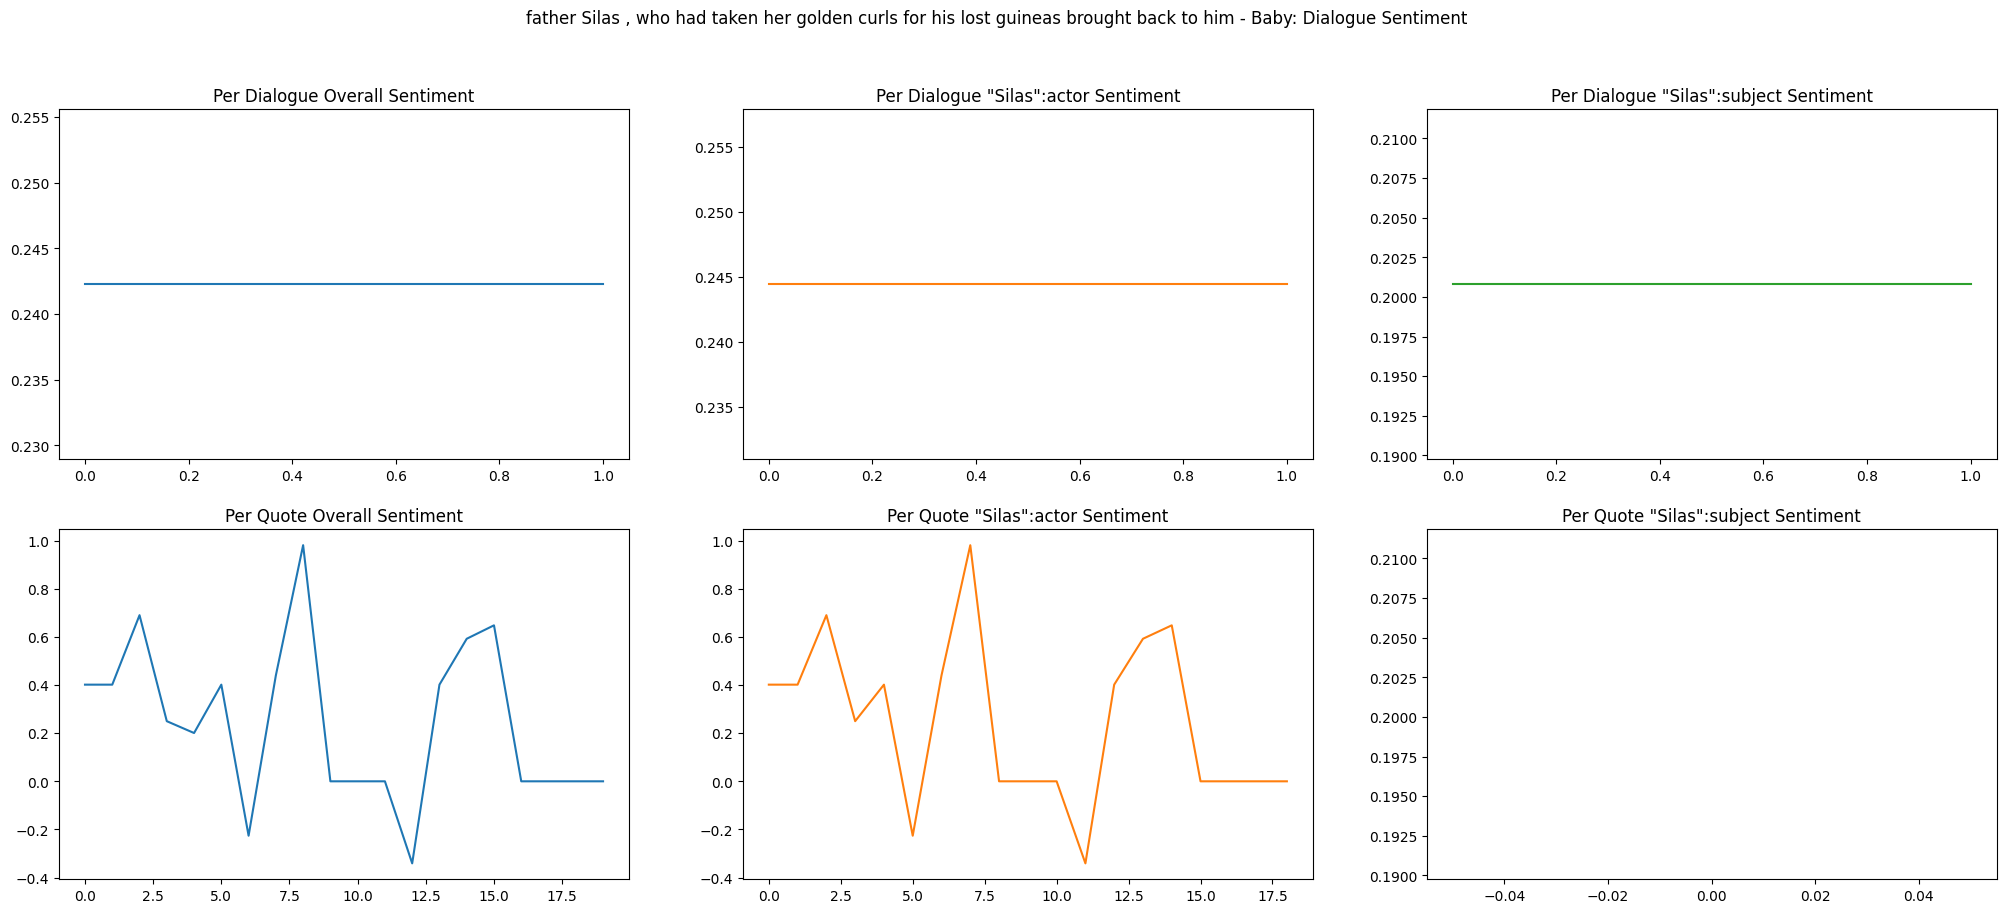

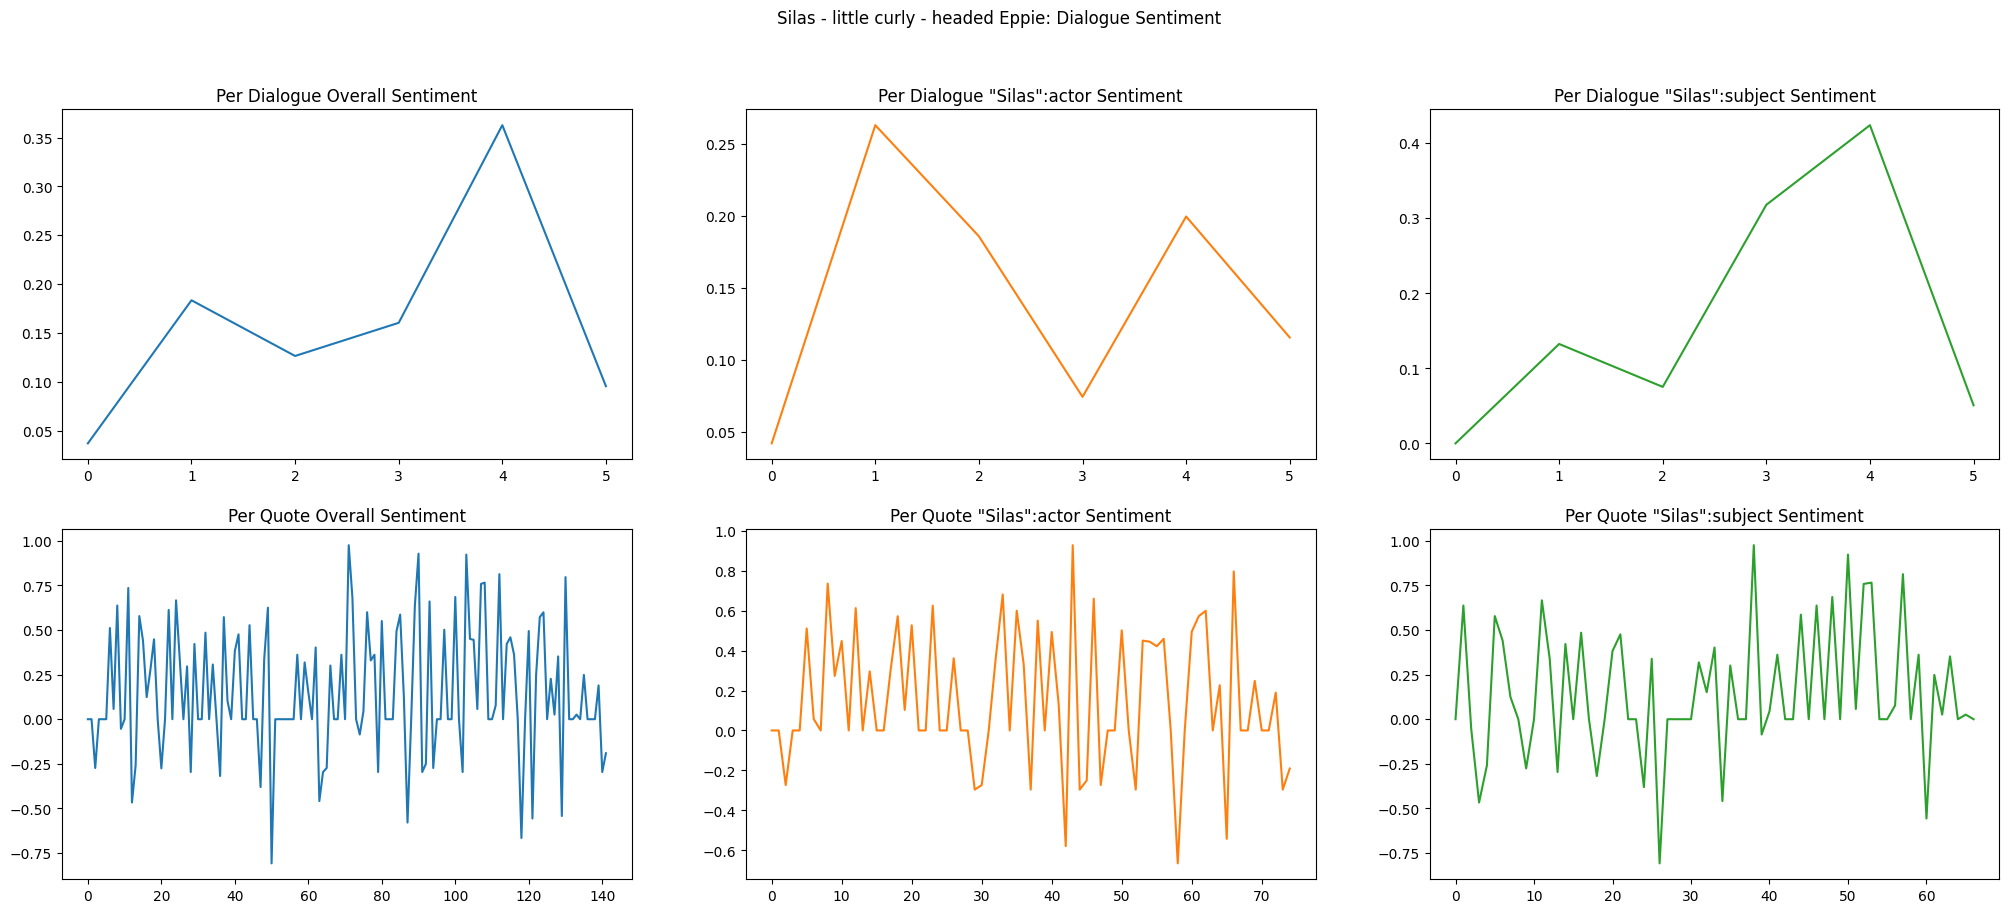

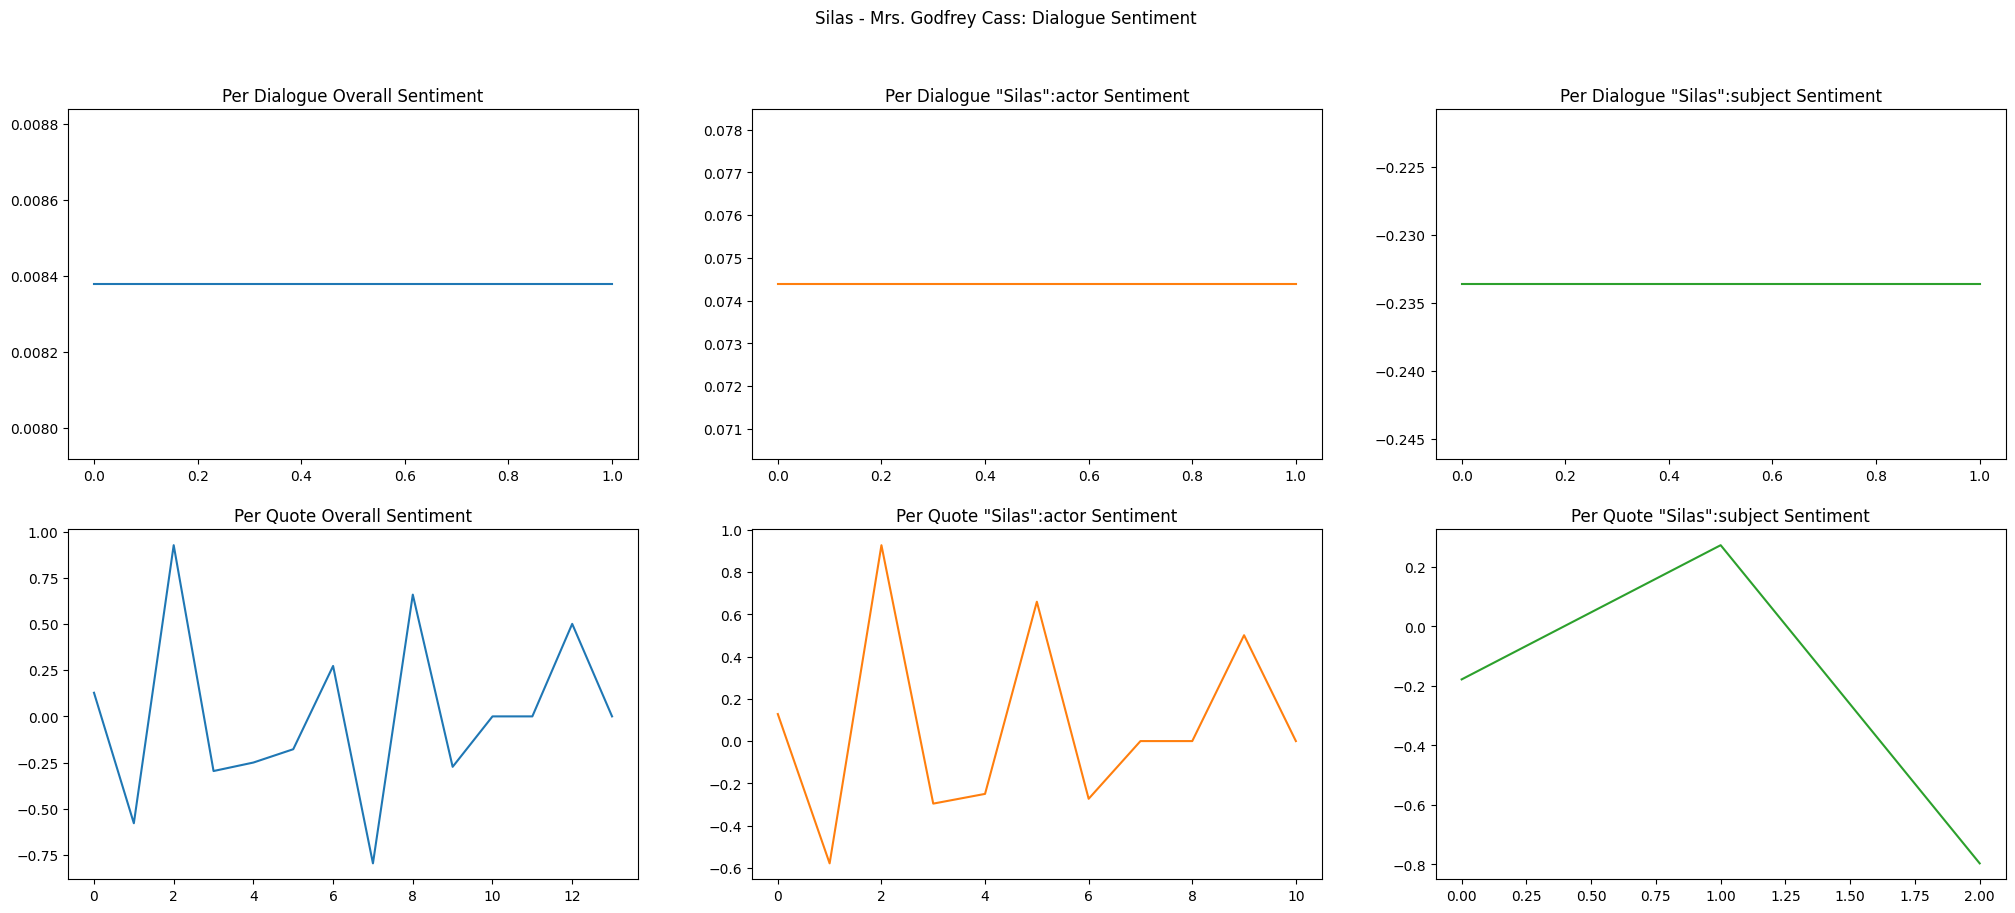

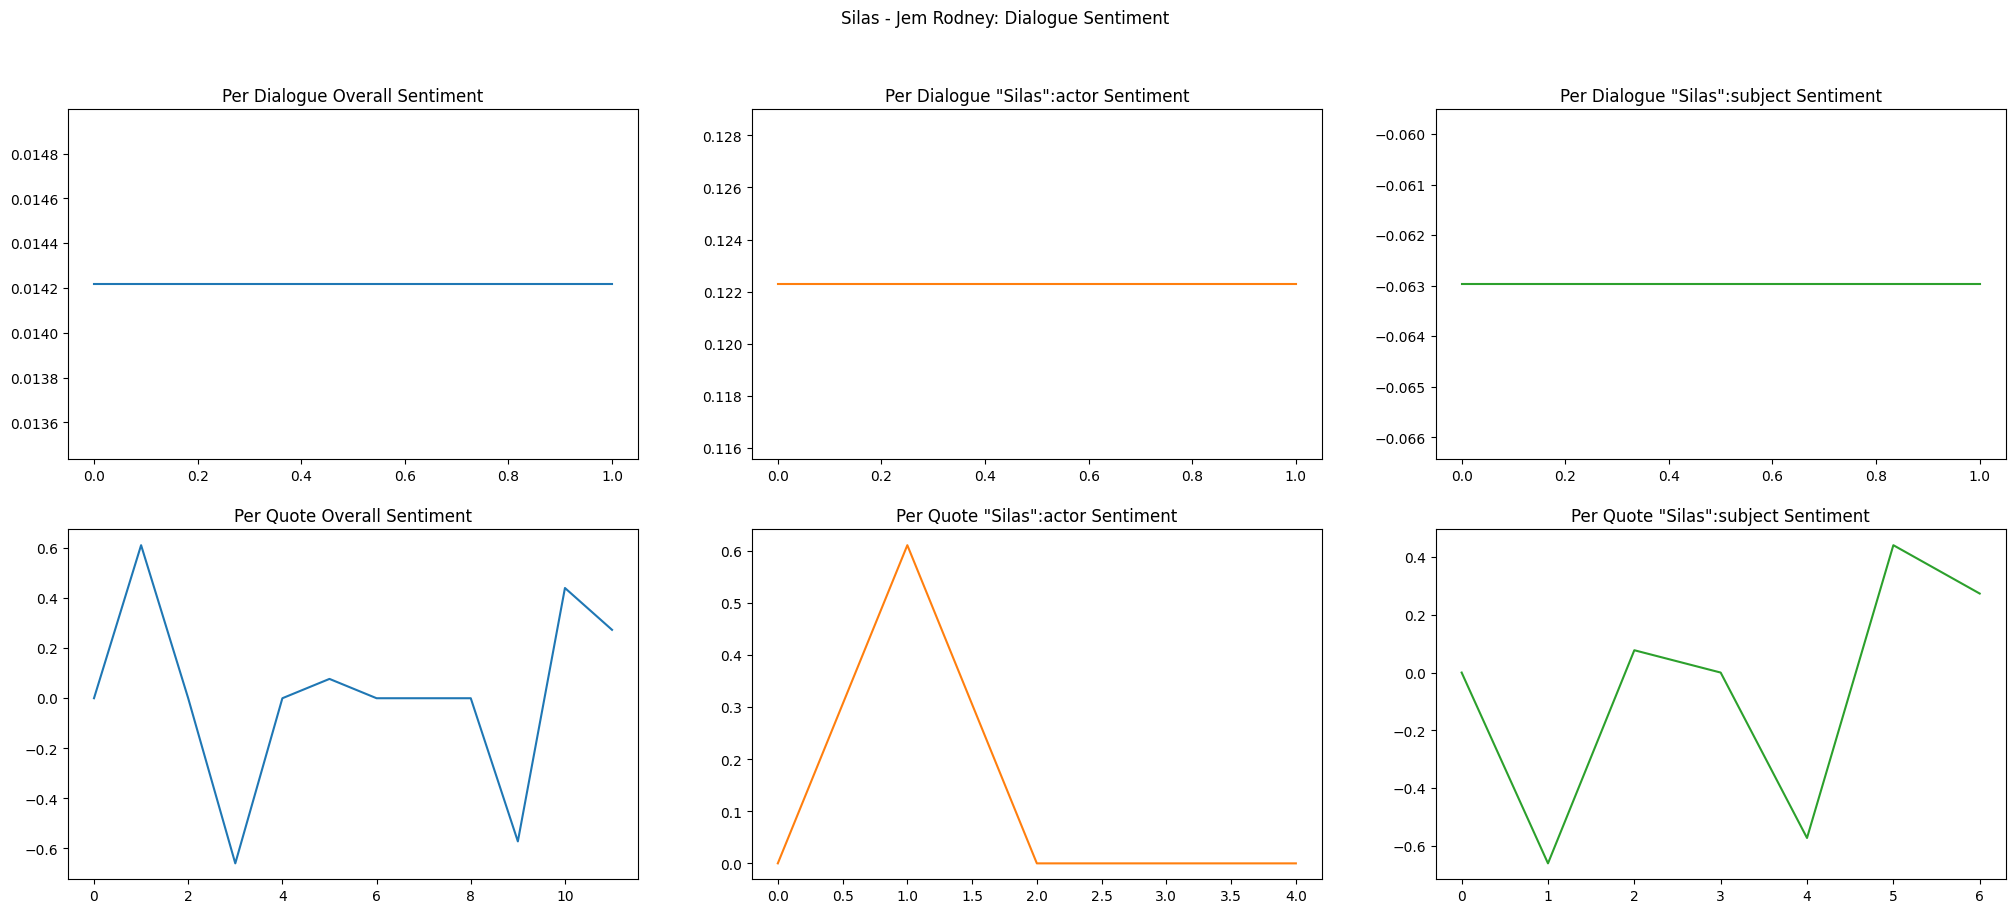

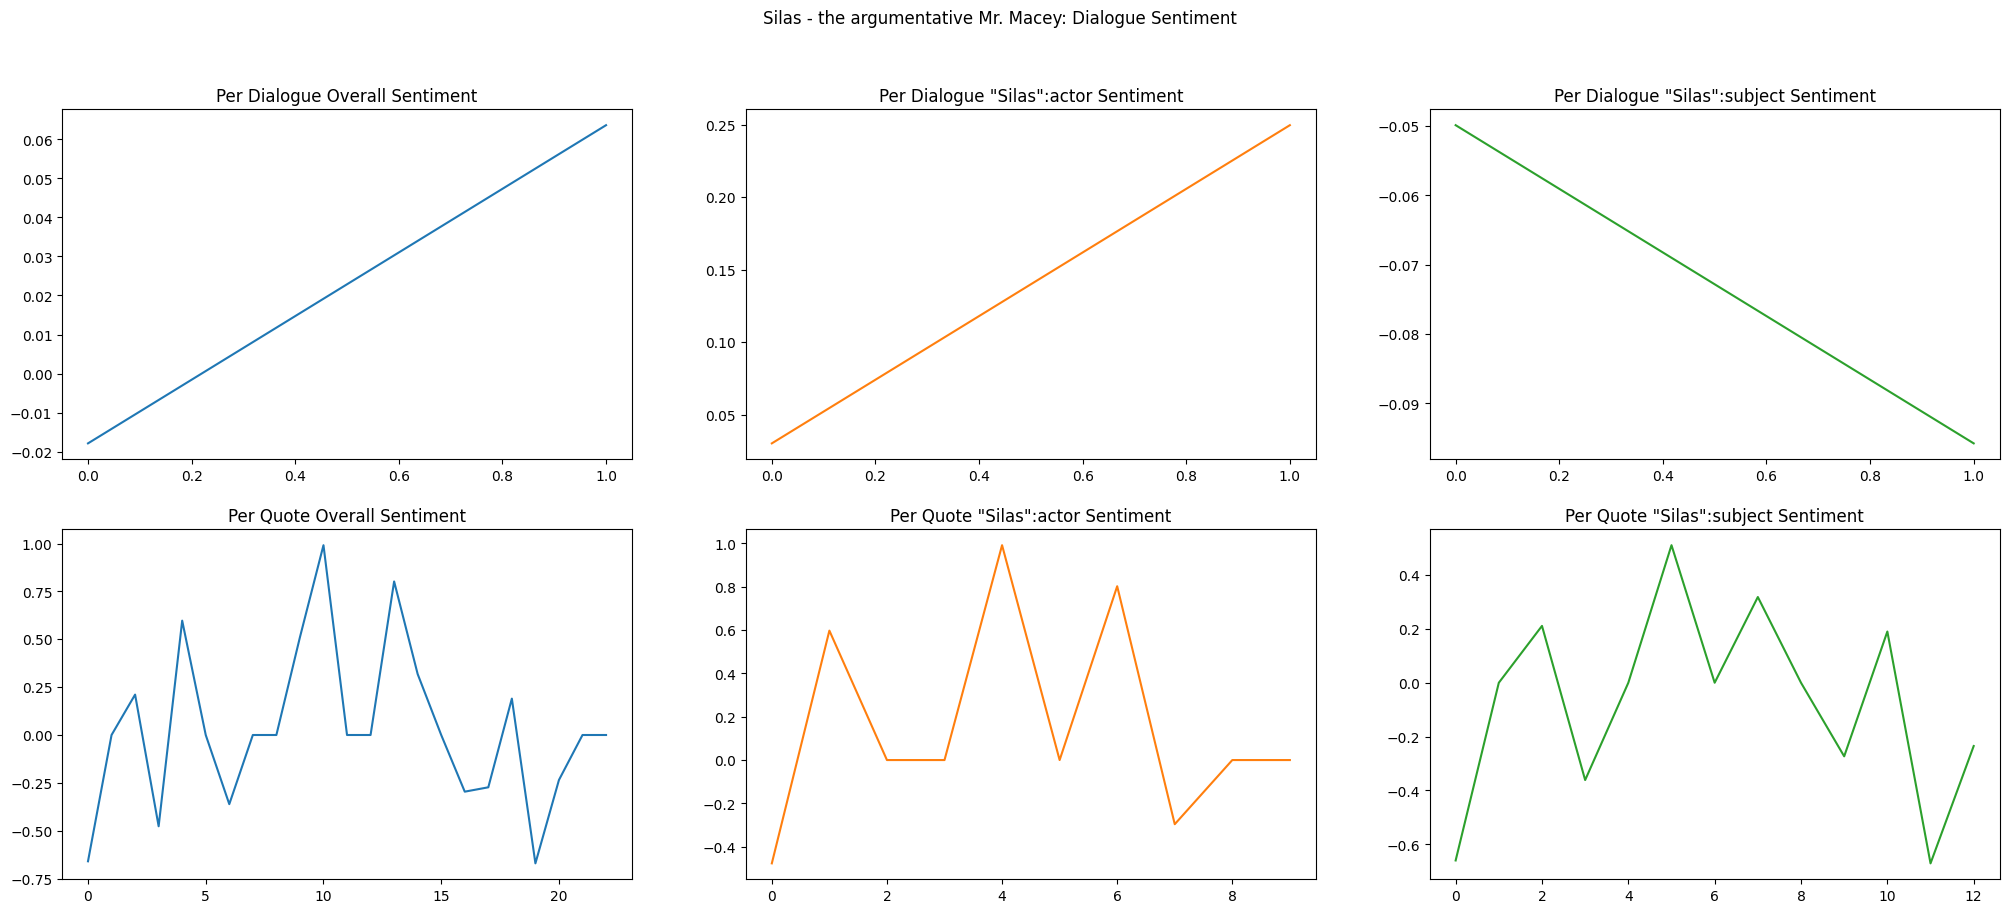

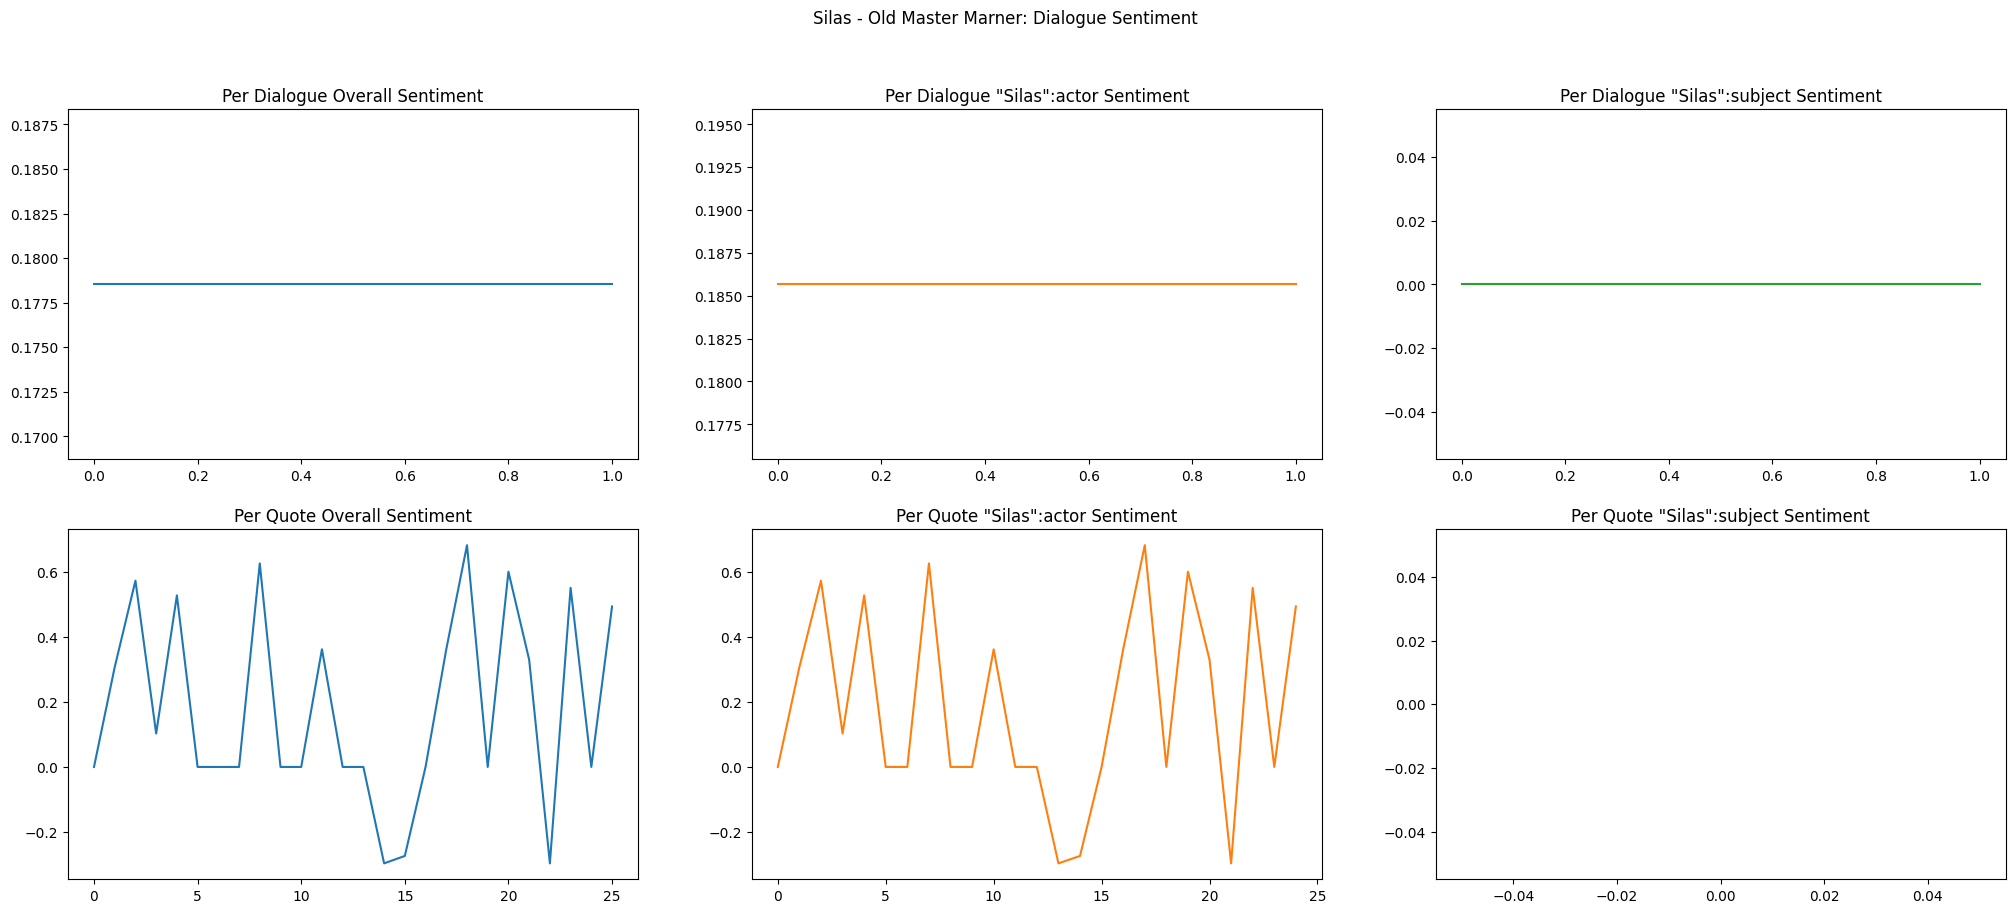

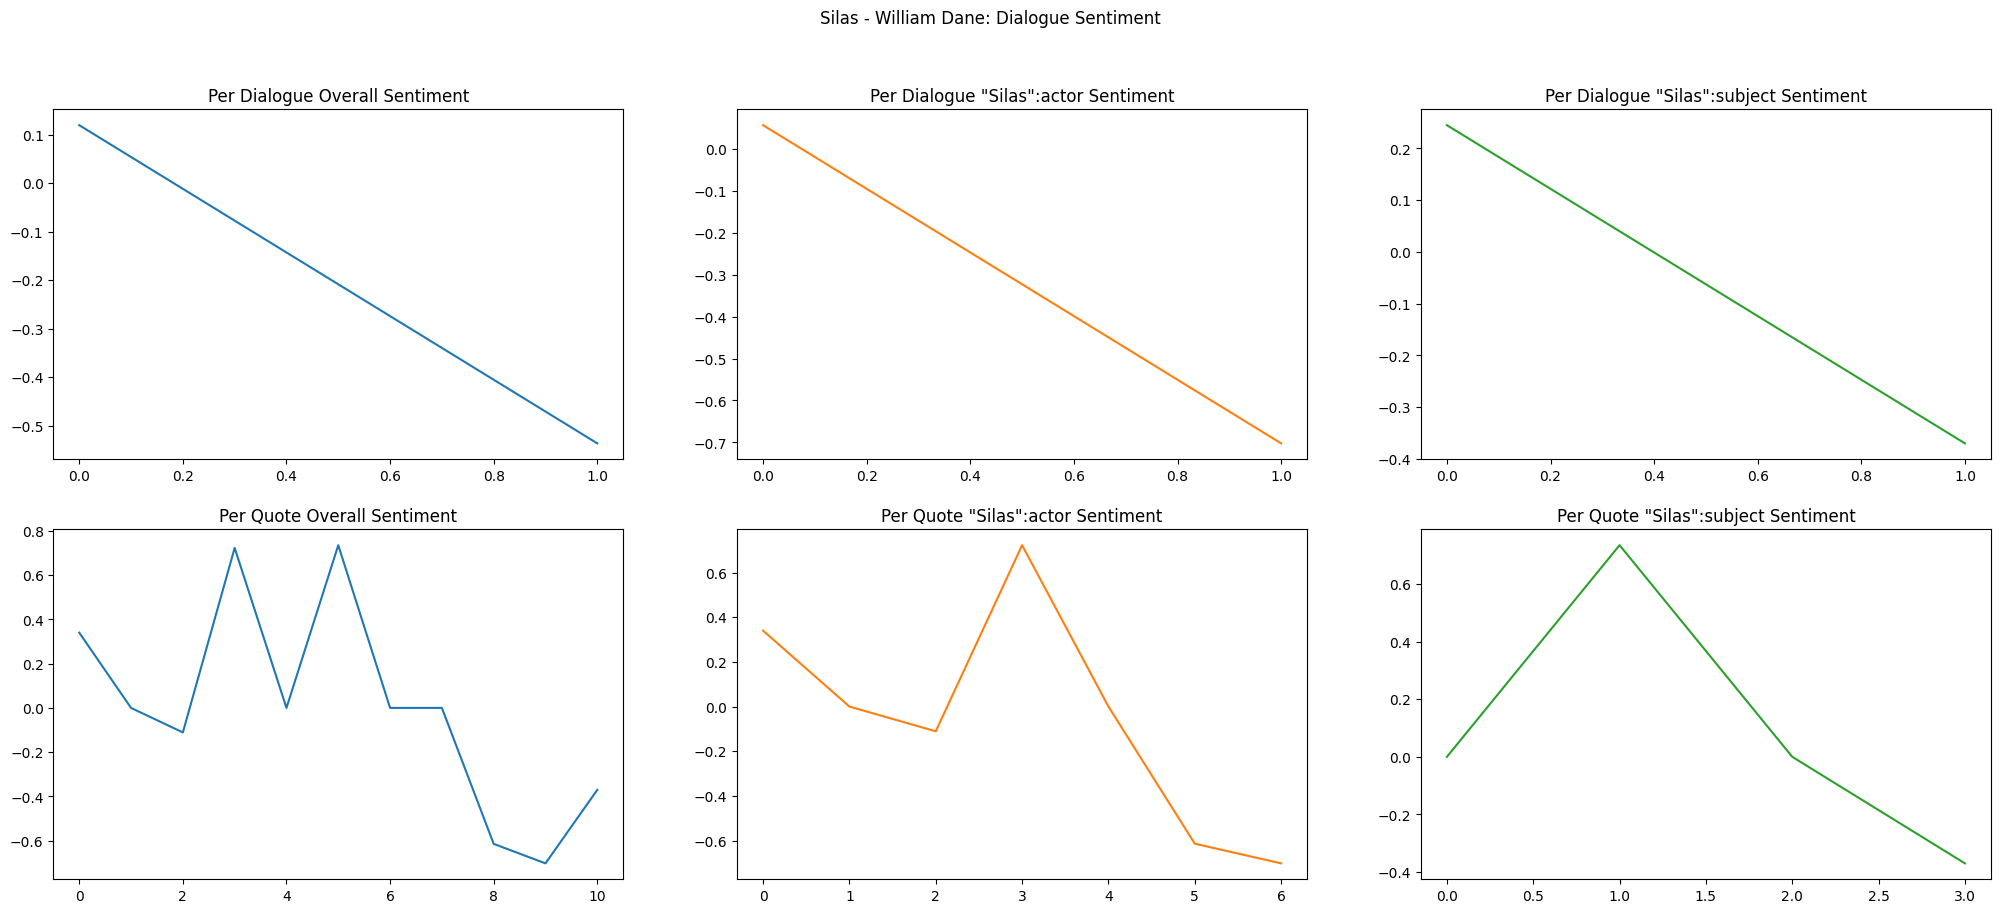

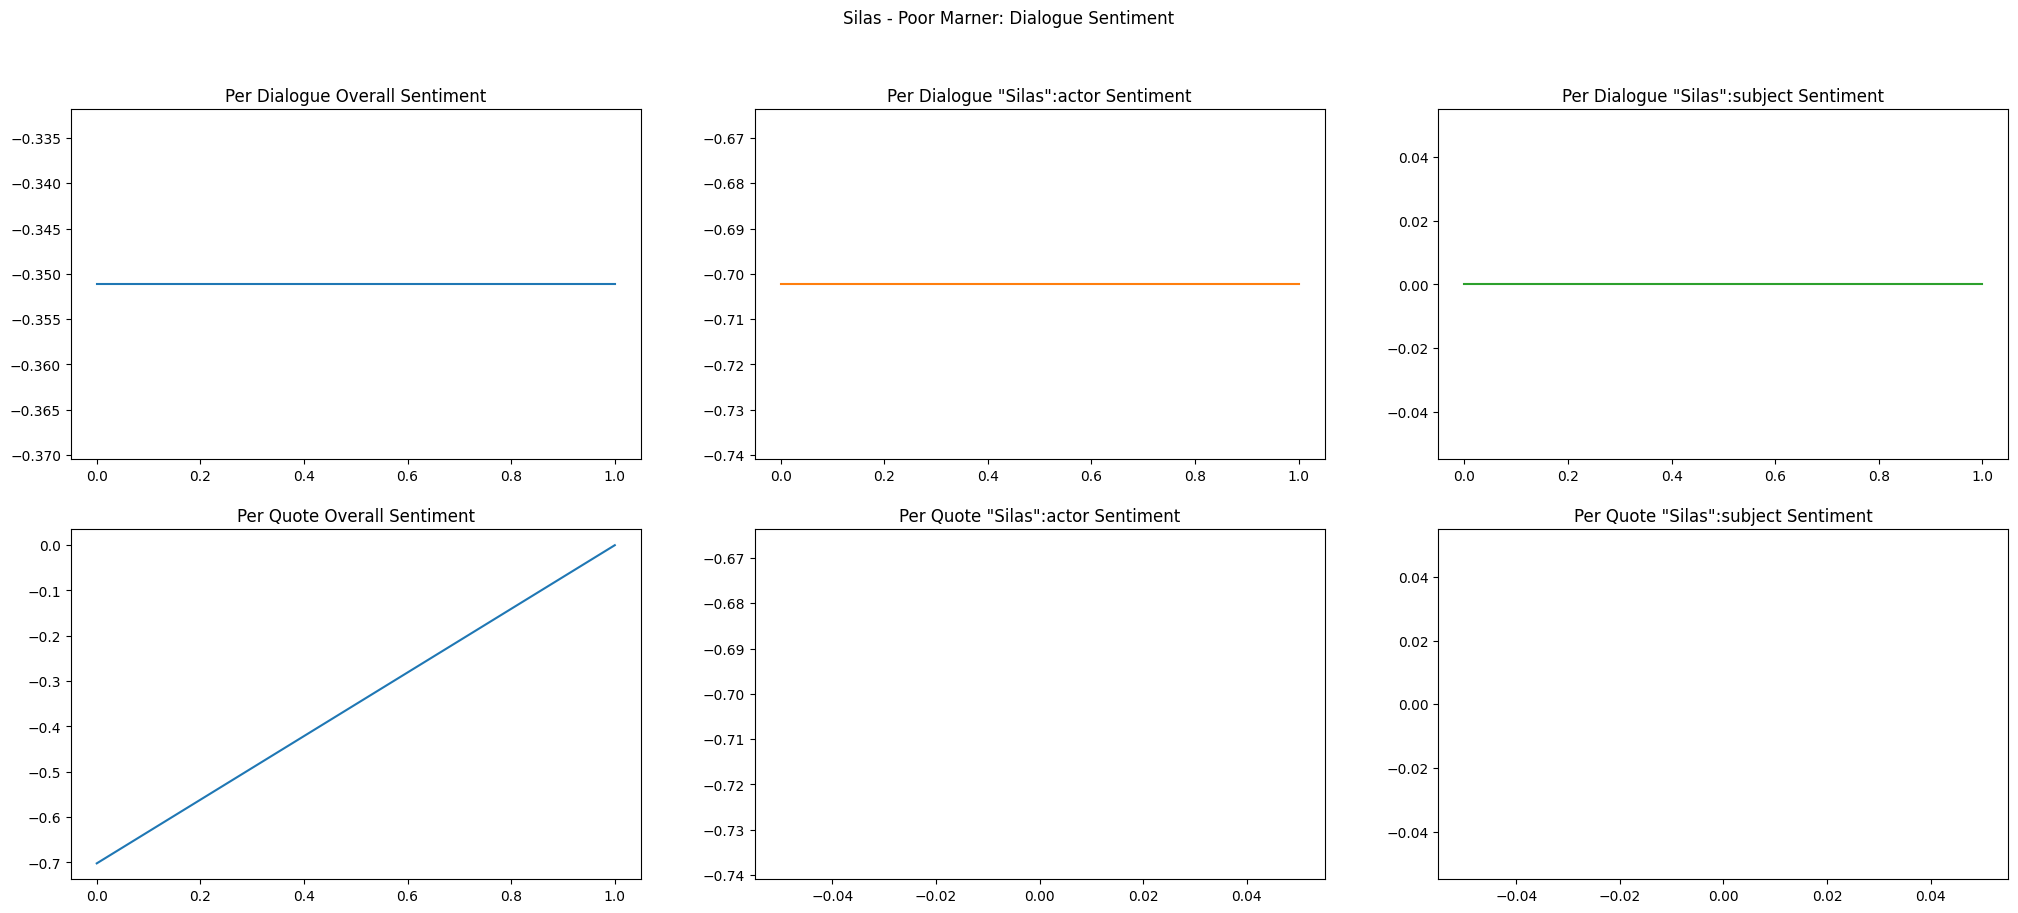

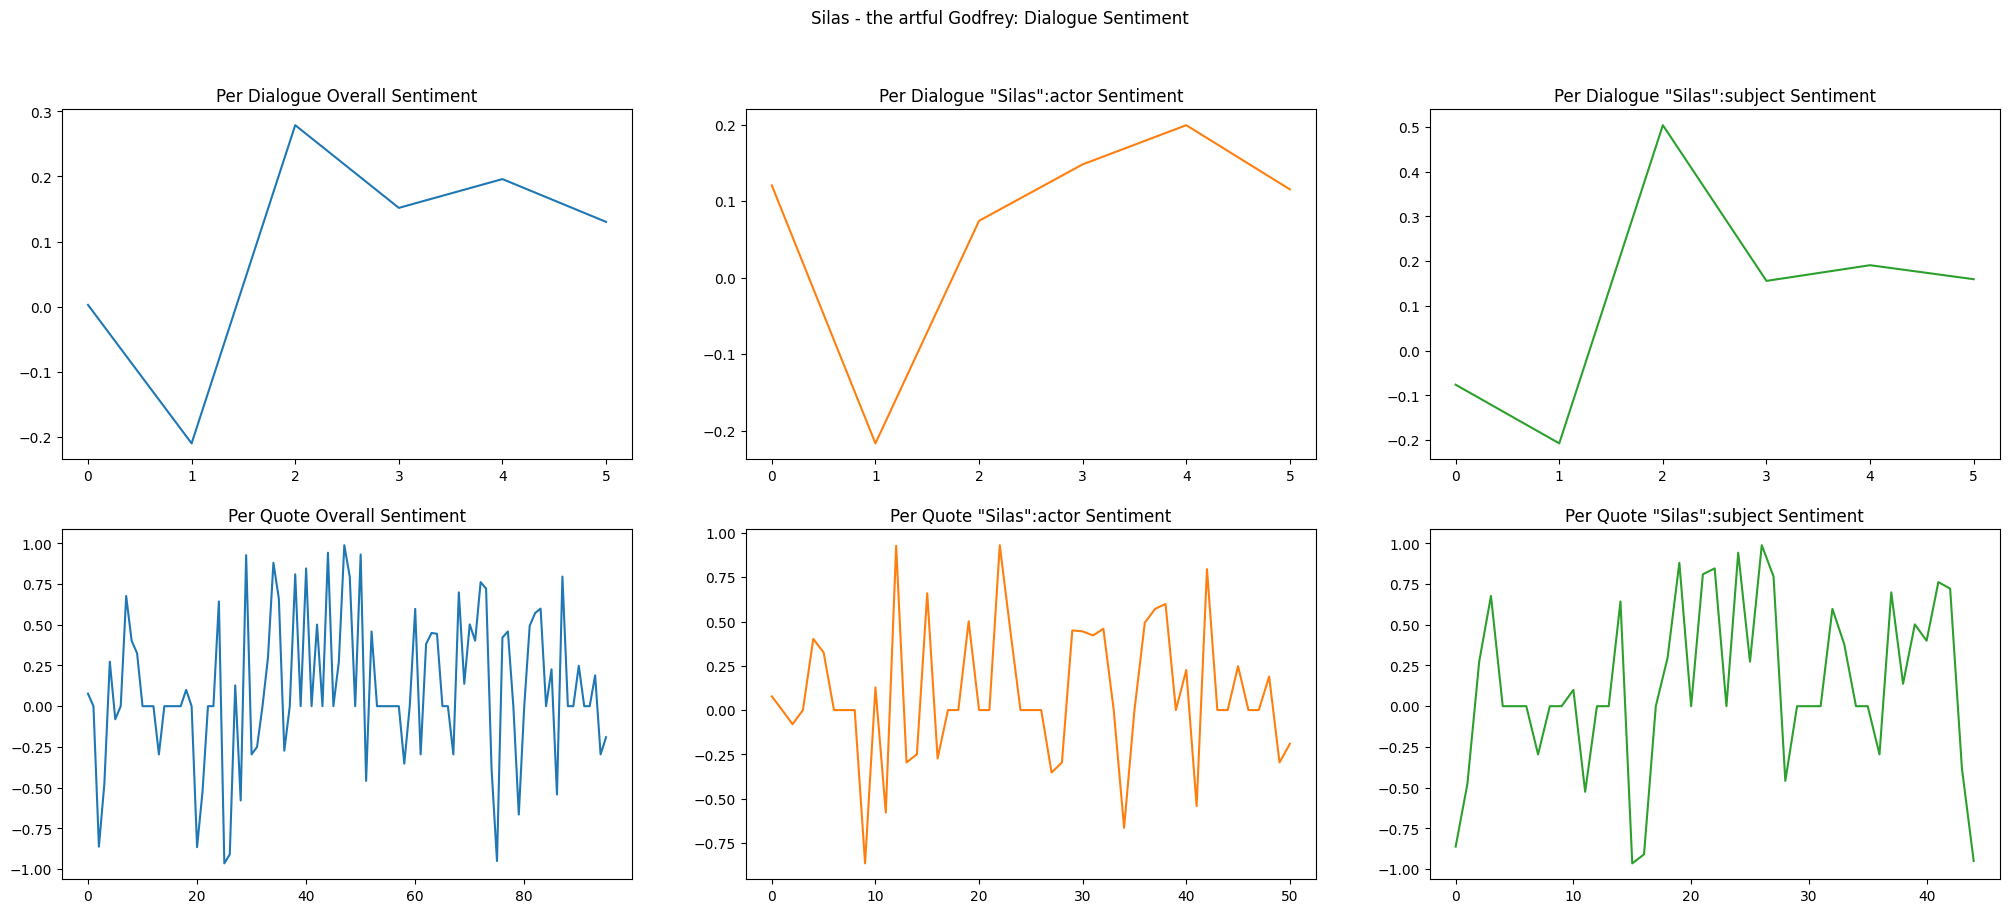

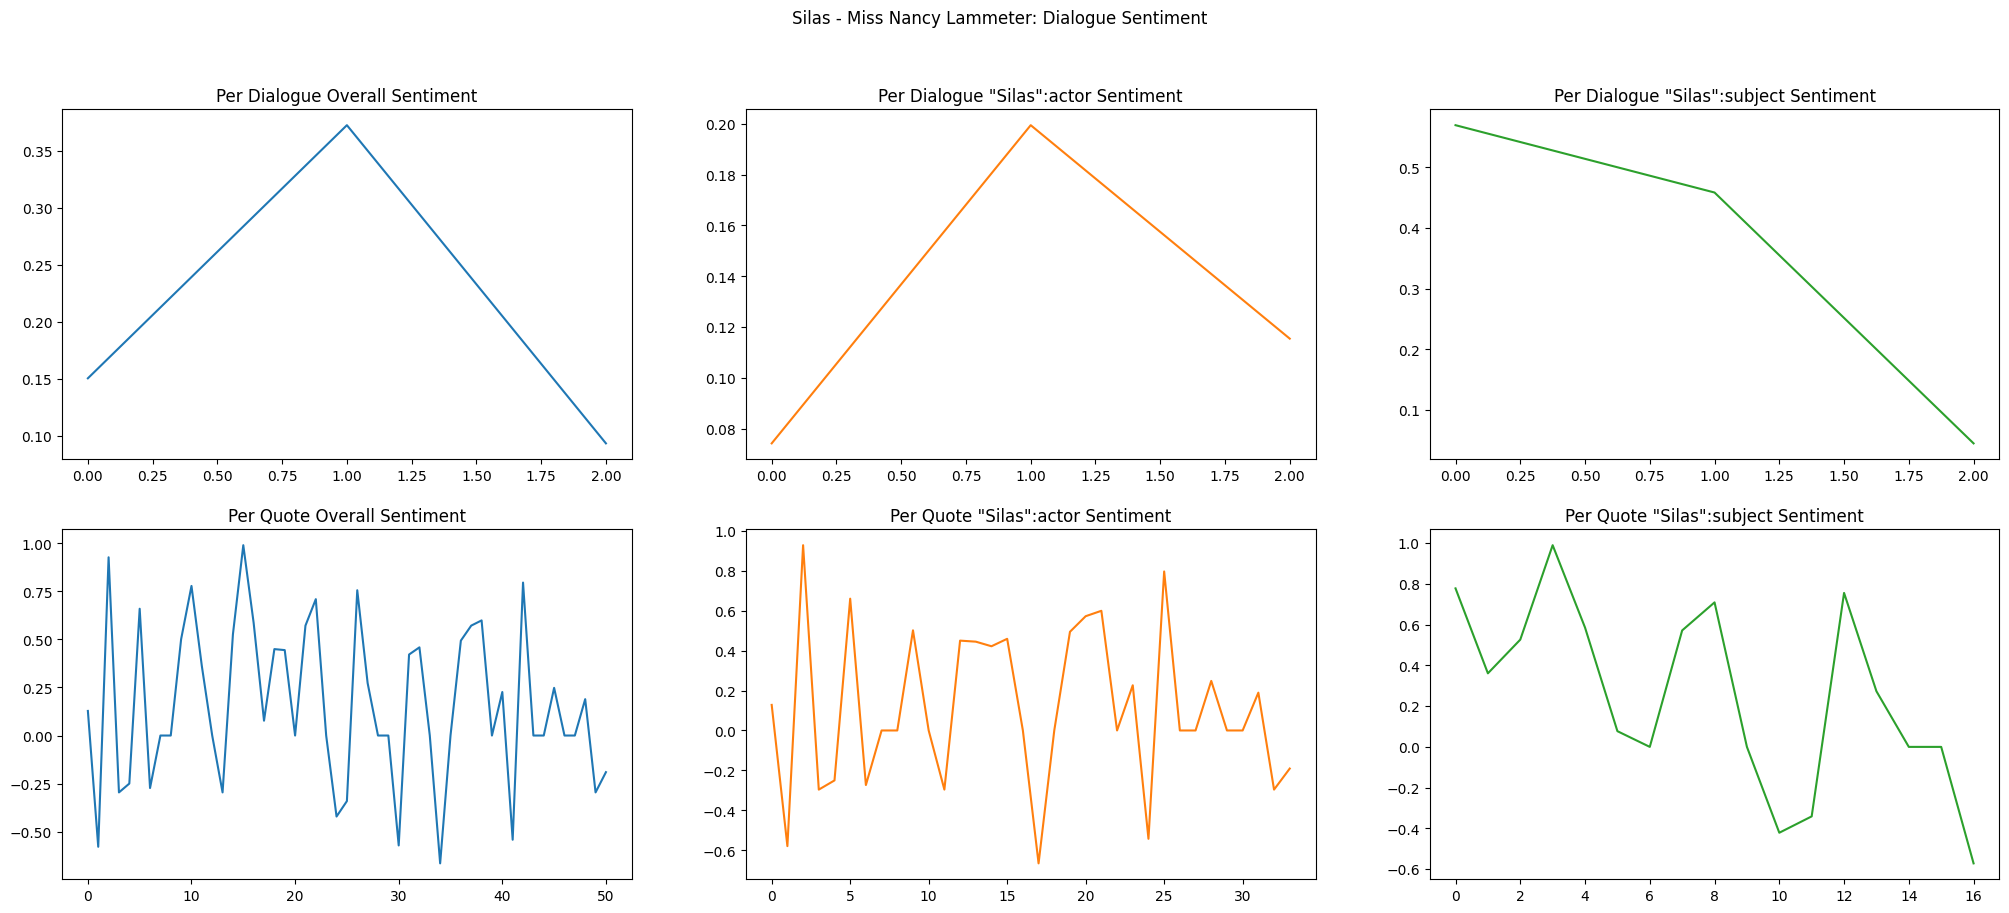

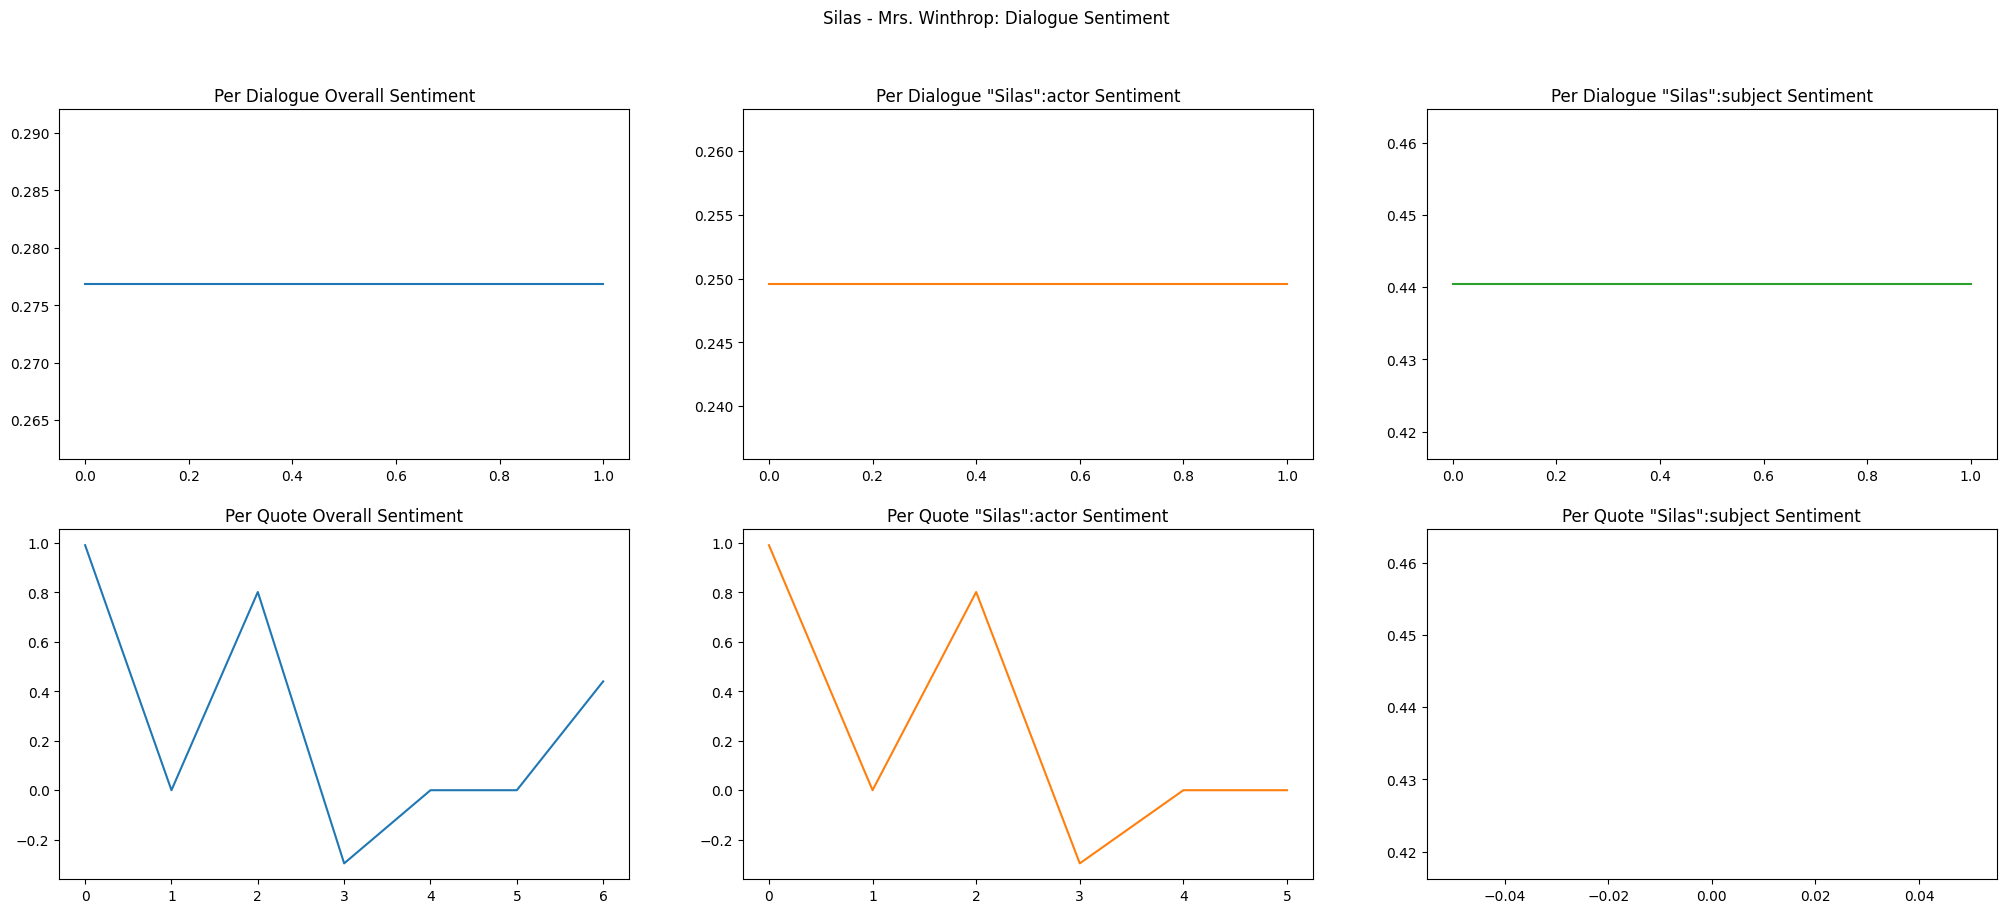

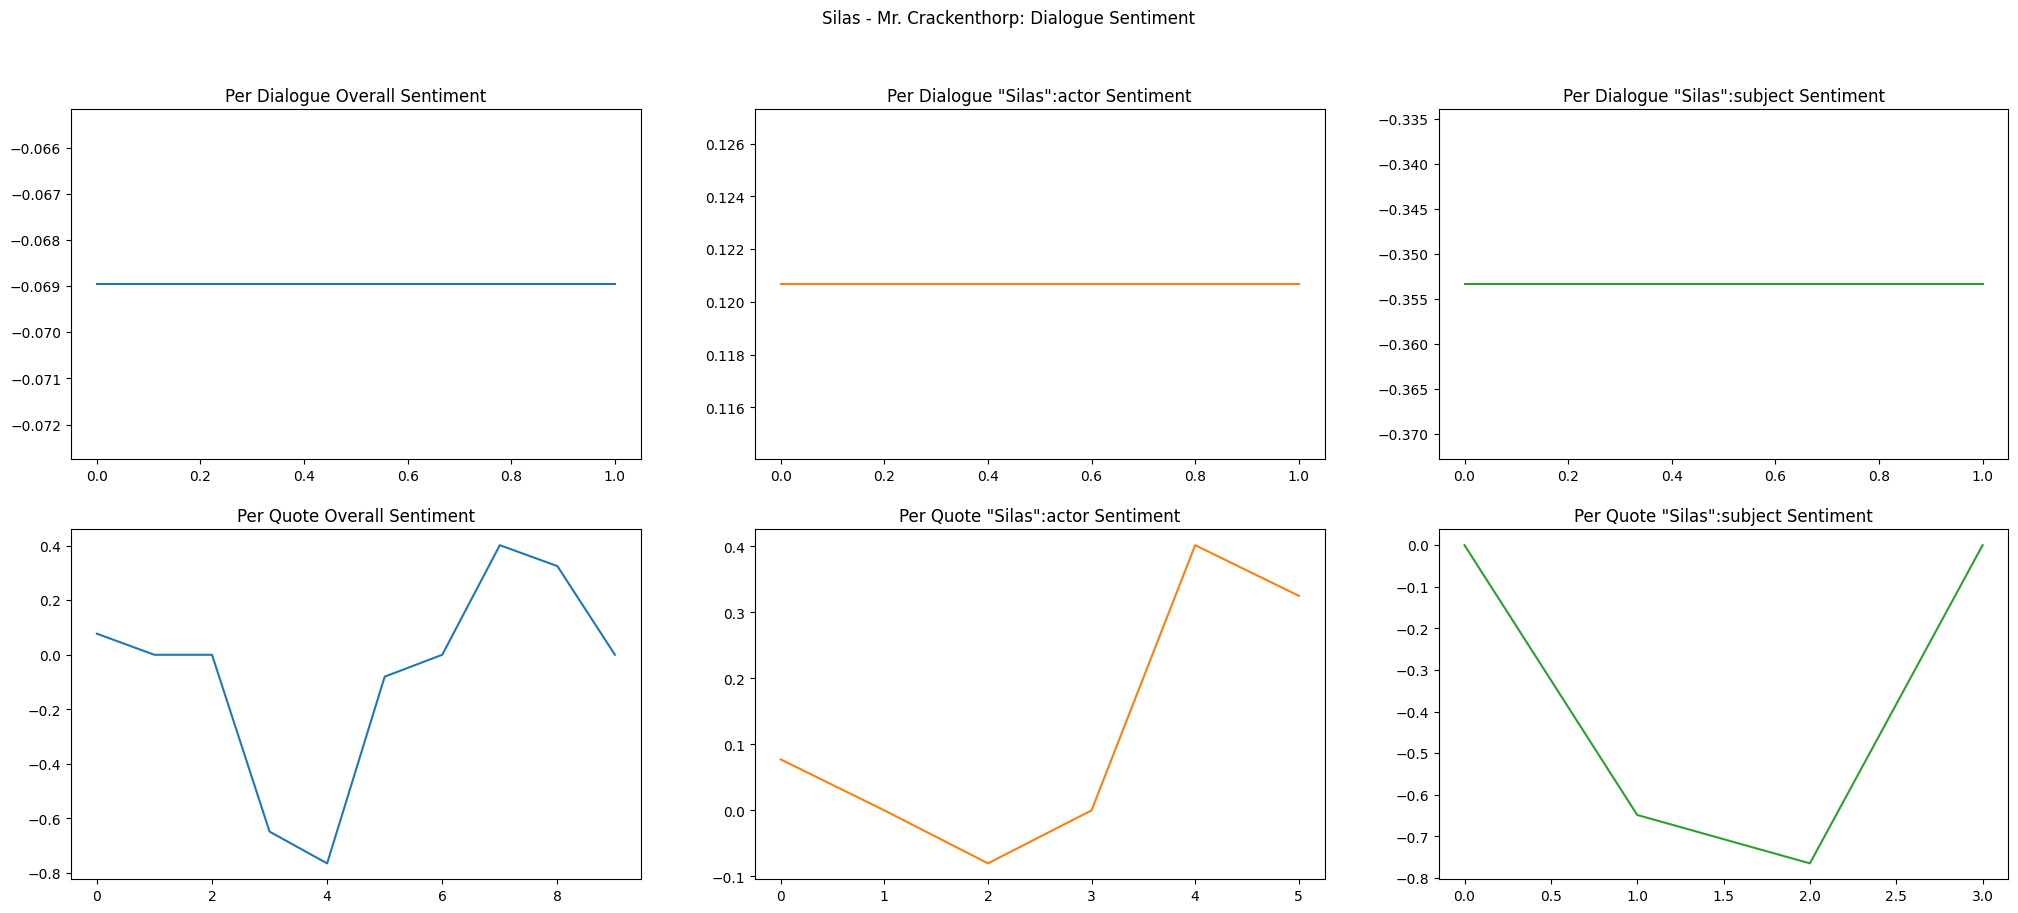

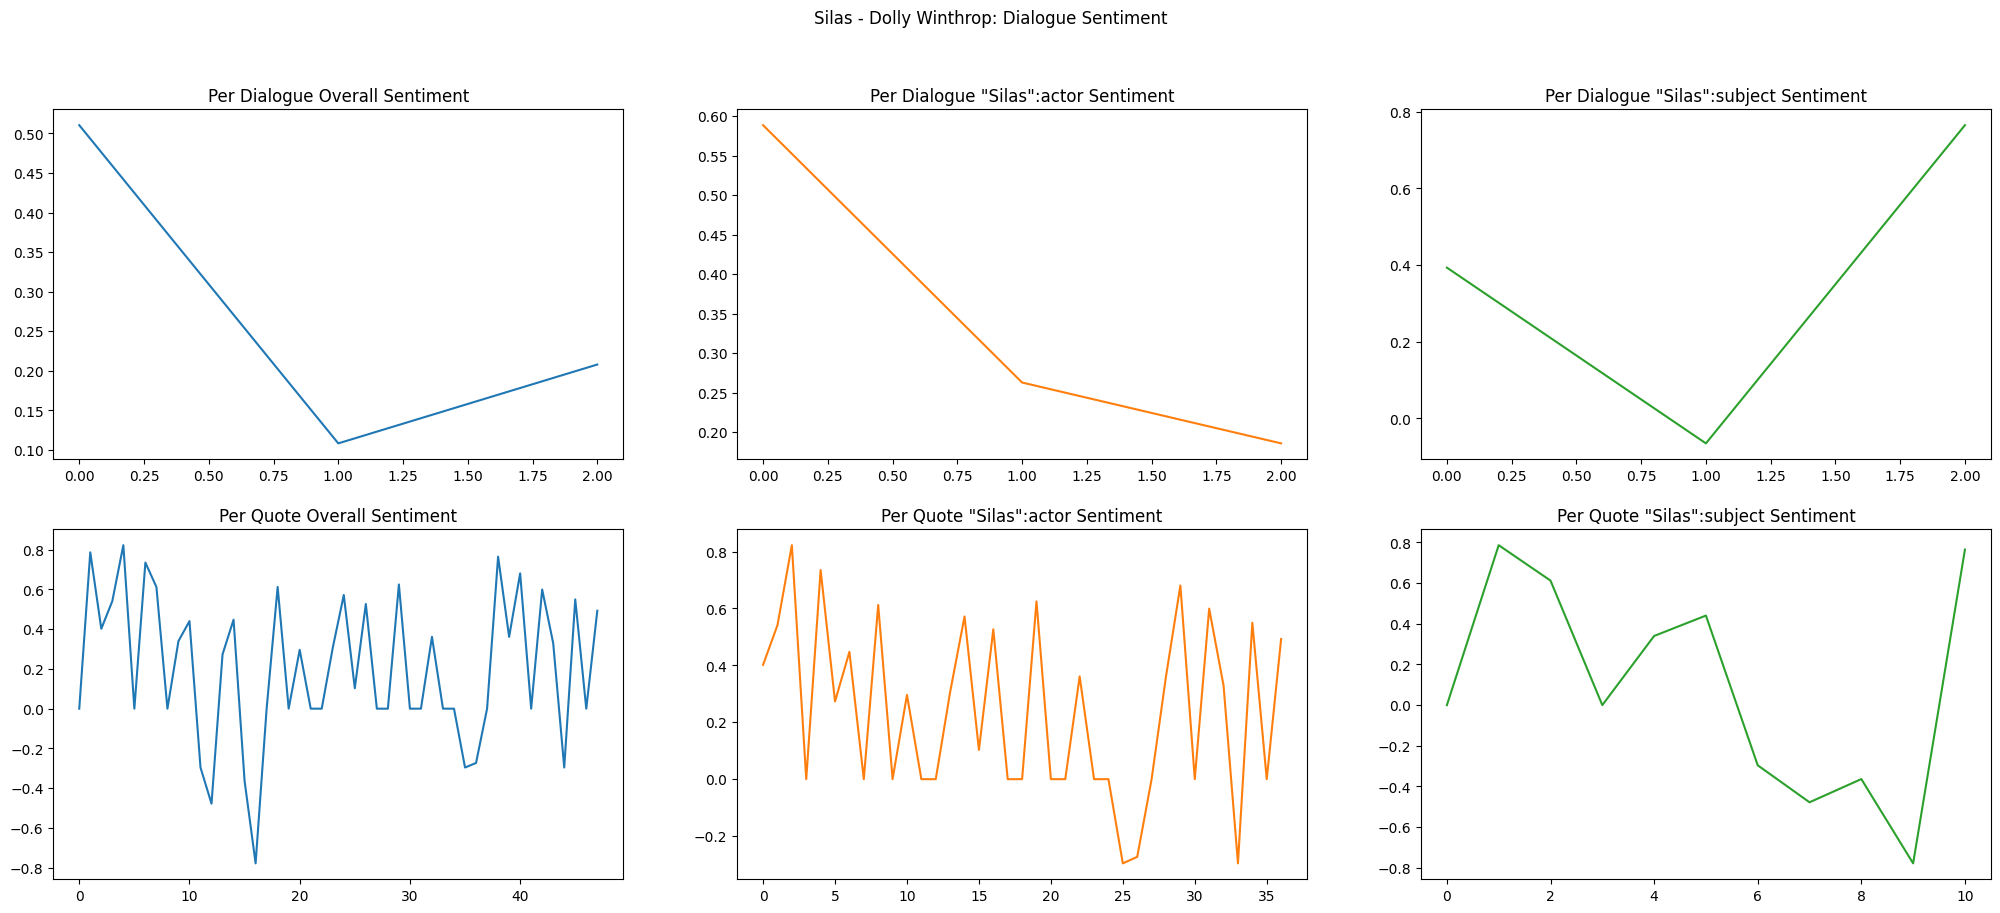

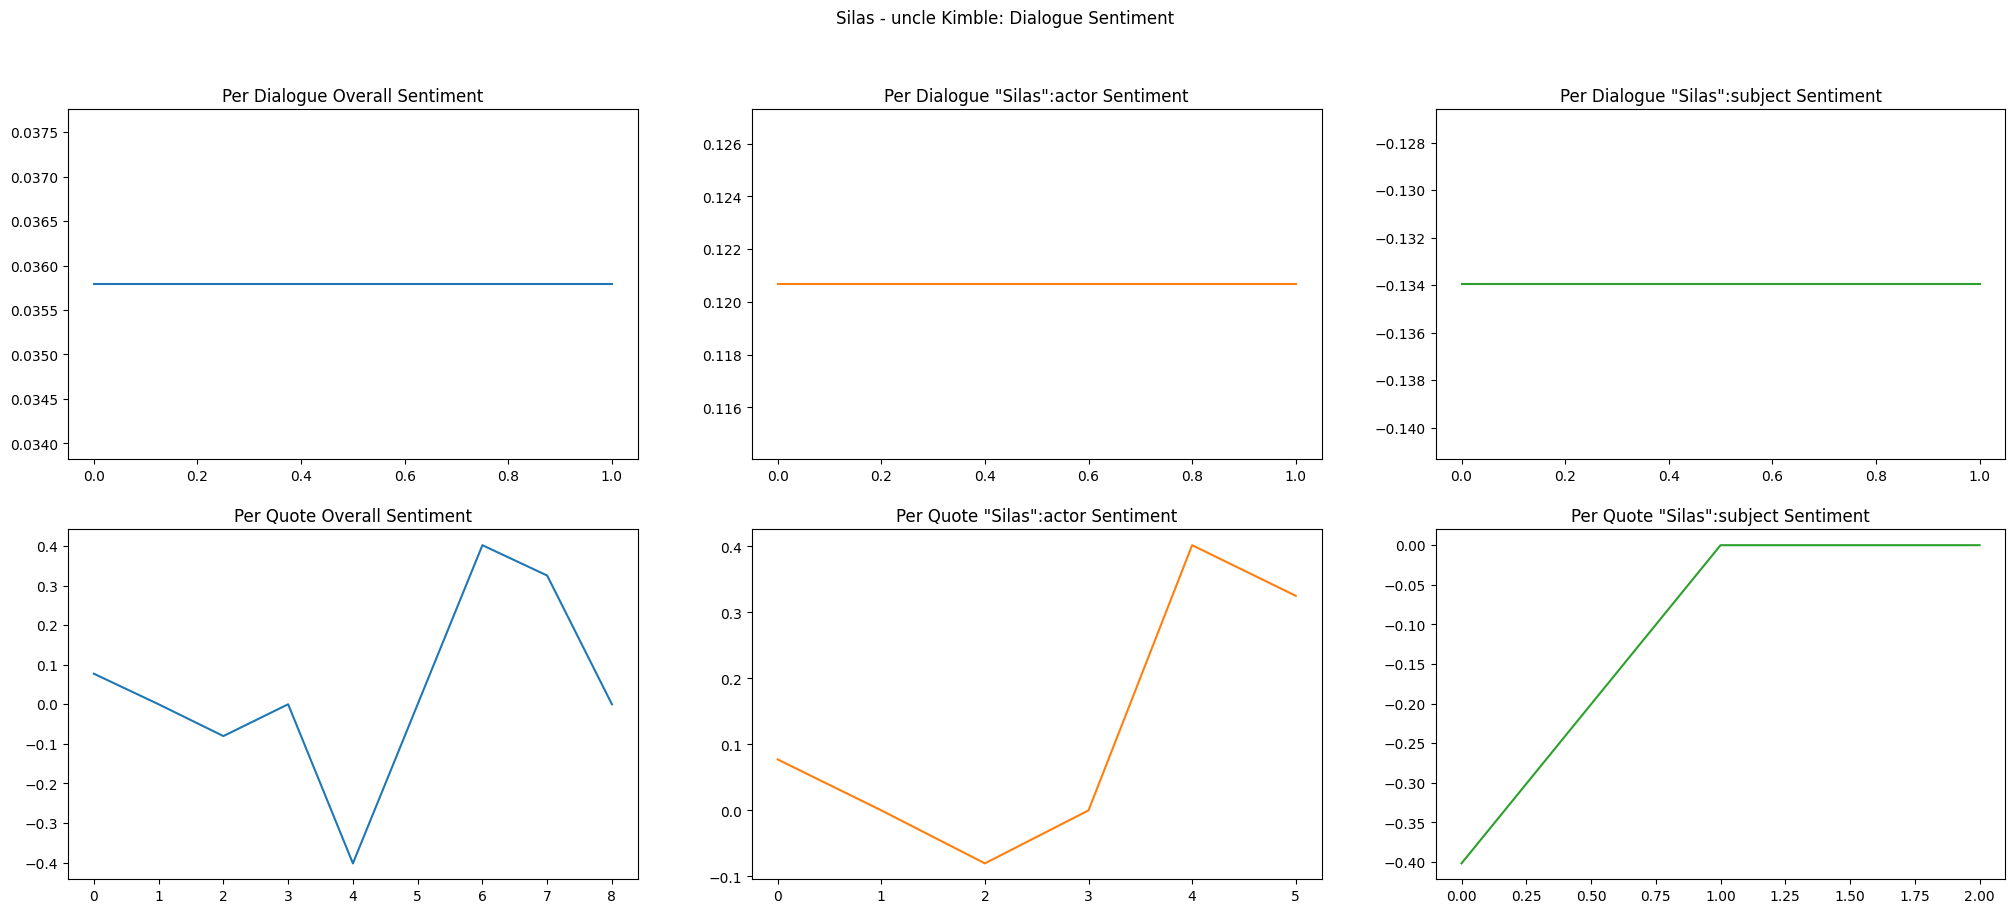

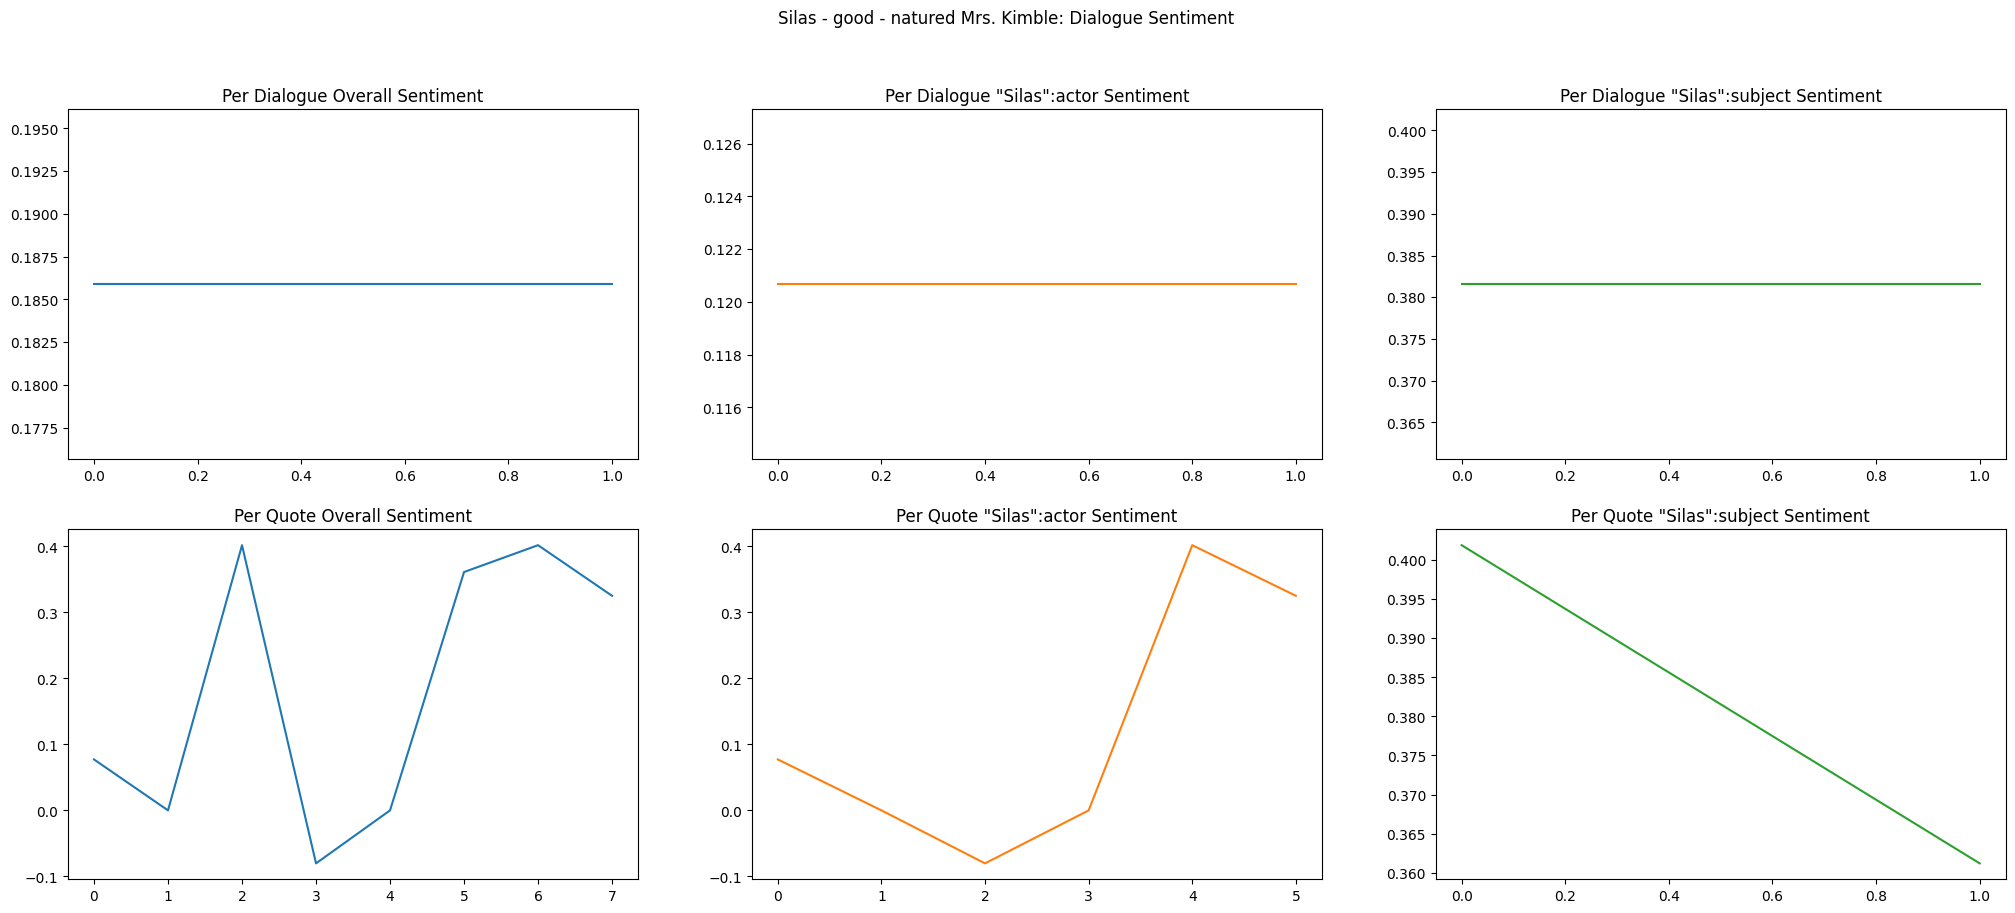

In [11]:
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


char_of_interest_id = char_id_lookup_reverse[character_of_interest]

sentiment_predictor = SentimentIntensityAnalyzer()

for character in filtered_other_characters:
    char_id = char_id_lookup_reverse[character]
    per_dialogue_overall_sentiment = []
    per_dialogue_coi_actor_sentiment = []
    per_dialogue_coi_subject_sentiment = []

    per_quote_overall_sentiment = []
    per_quote_coi_actor_sentiment = []
    per_quote_coi_subject_sentiment = []
    
    for dialogue in filtered_dialogues:
        if char_id not in dialogue.involved_characters:
            continue

        sent_overall = []
        sent_coi_actor = []
        sent_coi_subject = []

        for quote in dialogue.quotes:
            if not quote.speaker_id == char_id and not quote.speaker_id == char_of_interest_id:
                continue

            polarity = sentiment_predictor.polarity_scores(quote.text)['compound']
            sent_overall.append(polarity)
            if quote.speaker_id == char_id:
                sent_coi_subject.append(polarity)
            else:
                sent_coi_actor.append(polarity)

        per_dialogue_overall_sentiment.append(sum(sent_overall) / len(sent_overall))
        per_dialogue_coi_actor_sentiment.append(sum(sent_coi_actor) / len(sent_coi_actor))
        per_dialogue_coi_subject_sentiment.append(sum(sent_coi_subject) / len(sent_coi_subject))

        per_quote_overall_sentiment.extend(sent_overall)
        per_quote_coi_actor_sentiment.extend(sent_coi_actor)
        per_quote_coi_subject_sentiment.extend(sent_coi_subject)

    if len(per_dialogue_overall_sentiment) == 1:
        per_dialogue_overall_sentiment = 2 * per_dialogue_overall_sentiment
        per_dialogue_coi_actor_sentiment = 2 * per_dialogue_coi_actor_sentiment
        per_dialogue_coi_subject_sentiment = 2 * per_dialogue_coi_subject_sentiment
    
    fig, axs = plt.subplots(2, 3)
    fig.suptitle(f'{character_of_interest} - {character}: Dialogue Sentiment')

    character_of_interest = 'Silas'
    
    axis = np.arange(len(per_dialogue_overall_sentiment))
    axs[0, 0].plot(axis, per_dialogue_overall_sentiment)
    axs[0, 0].set_title('Per Dialogue Overall Sentiment')

    axis = np.arange(len(per_dialogue_coi_actor_sentiment))
    axs[0, 1].plot(axis, per_dialogue_coi_actor_sentiment, 'tab:orange')
    axs[0, 1].set_title(f'Per Dialogue "{character_of_interest}":actor Sentiment')

    axis = np.arange(len(per_dialogue_coi_subject_sentiment))
    axs[0, 2].plot(axis, per_dialogue_coi_subject_sentiment, 'tab:green')
    axs[0, 2].set_title(f'Per Dialogue "{character_of_interest}":subject Sentiment')

    axis = np.arange(len(per_quote_overall_sentiment))
    axs[1, 0].plot(axis, per_quote_overall_sentiment)
    axs[1, 0].set_title('Per Quote Overall Sentiment')

    axis = np.arange(len(per_quote_coi_actor_sentiment))
    axs[1, 1].plot(axis, per_quote_coi_actor_sentiment, 'tab:orange')
    axs[1, 1].set_title(f'Per Quote "{character_of_interest}":actor Sentiment')

    axis = np.arange(len(per_quote_coi_subject_sentiment))
    axs[1, 2].plot(axis, per_quote_coi_subject_sentiment, 'tab:green')
    axs[1, 2].set_title(f'Per Quote "{character_of_interest}":subject Sentiment')
    
    plt.show()

In [12]:
per_dialogue_overall_sentiment

[0.18588749999999998, 0.18588749999999998]

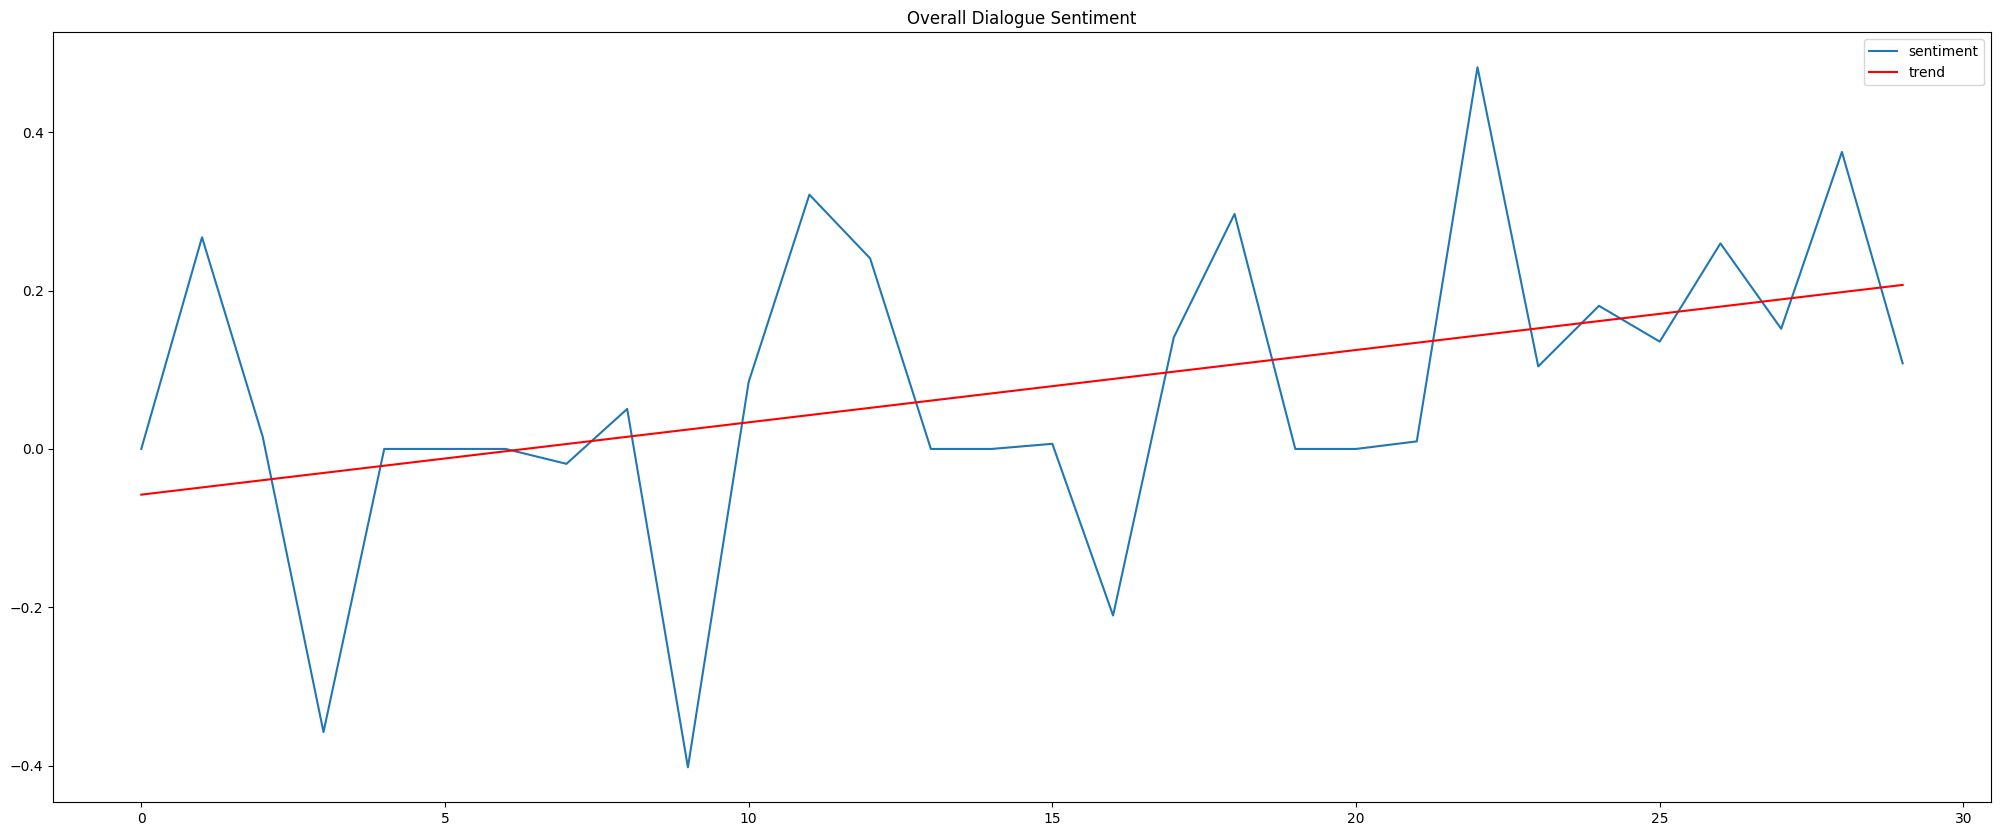

In [14]:
dialogue_sentiments = []

for dialogue in filtered_dialogues:
    sentiments = []
    for quote in dialogue.quotes:
        polarity = sentiment_predictor.polarity_scores(quote.text)['compound']
        sentiments.append(polarity)
    dialogue_sentiments.append(sum(sentiments) / len(sentiments))

x = np.arange(len(dialogue_sentiments))
slope, intercept = np.polyfit(x, dialogue_sentiments, 1)

plt.plot(x, dialogue_sentiments, label='sentiment')
plt.plot(x, slope*x + intercept, color='red', label='trend')
plt.title('Overall Dialogue Sentiment')
plt.legend()
plt.show()